In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
from datetime import datetime, date, time, timezone
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import mglearn
from IPython.display import display

import glob
import os

# Dataset 3: FedEx orders with box dim

In [13]:
cols_list = ['Reference 2','Dim length', 'Dim width', 'Dim height']

files = glob.glob('/Users/elle.le/Workspace/BoxSize_local/new_data/FedEx_box/*.csv')

dfs =[]

for file in files:
    dfs.append(pd.read_csv(file, usecols = cols_list))

box_size = pd.concat(dfs, axis = 0, ignore_index = True, sort = False)
box_size.dropna(subset=['Dim height','Reference 2'], inplace = True)
box_size.rename(columns = {'Reference 2':'order_number'}, inplace = True)

box_size = box_size[['order_number','Dim length', 'Dim width', 'Dim height']]
box_size['box_vol']=box_size['Dim length']*box_size['Dim width']*box_size['Dim height']
print(box_size.shape)
box_size.head(5)

(594891, 5)


,order_number,Dim length,Dim width,Dim height,box_vol
0,791V-YVBD,11.0,8.0,6.0,528.0
1,YQ28-PKTY,15.0,10.0,4.0,600.0
2,1S2M-BKQM,10.0,15.0,6.0,900.0
3,XC5S-4MLT,10.0,7.0,4.0,280.0
4,KZJH-PQN2,11.0,8.0,6.0,528.0


In [6]:
#Unique orders with shipping box size
box_size_GM = pd.merge(GM_order, box_size, how ='left', on ='order_number')

box_size_GM.dropna(subset=['Dim height','order_number'], inplace = True)

box_size_GM.shape

NameError: name 'GM_order' is not defined

In [ ]:
# Sort 3 dim to create unique box profile
tmp_item = box_sise_GM.iloc[:,1:4].apply(sorted, axis=1)
tmp_item = pd.DataFrame(tmp_item.to_list(), columns=['dim1','dim2','dim3'])
box_size_GM.iloc[:,1:4] = tmp_item.copy().to_numpy()

box_size_GM.head(5)

In [ ]:
#K-means to decide number of box groups:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(box_size_GM.iloc[:,1:4])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()  

In [ ]:
FedEx_box_type = 3
kmeans_box = KMeans(n_clusters=FedEx_box_type, random_state=0, max_iter = 1000).fit(box_size_GM.iloc[:,1:4])
box_size_GM['FedEx_box_type'] = kmeans_box.labels_
box_size_GM.head(3)
box_label = box_size_GM.drop(columns = ['Dim length','Dim width','Dim height','box_vol']).copy()
print(box_label.shape)
box_label.head(3)

In [ ]:
cfig = plt.figure()
ax = cfig.add_subplot(111, projection='3d')
classes = kmeans_box.labels_
colors = cm.rainbow(np.linspace(0, 1, FedEx_box_type))
for i in range(FedEx_box_type):
    x=box_size_GM.loc[classes == i, 'Dim length']
    y=box_size_GM.loc[classes == i, 'Dim width']
    z=box_size_GM.loc[classes == i, 'Dim height']
    ax.scatter(x, y,z,c=colors[i])

In [ ]:
box_size_GM['FedEx_box_type'].hist()

In [ ]:
box_size_GM.loc[box_size_GM['FedEx_box_type'] == 0 ]['box_vol'].hist()

In [ ]:
box_size_GM.loc[box_size_GM['FedEx_box_type'] == 1 ]['box_vol'].hist()

In [ ]:
box_size_GM.loc[box_size_GM['FedEx_box_type'] == 2 ]['box_vol'].hist()

# Dataset 2: Order Line Item

In [ ]:
line = pd.read_csv('new_data/GM_2019_2020_orders_FedEx.csv')
print(line.shape)
line.drop(columns = ['tracking_number'], inplace = True)
line.head(2)

In [ ]:
line['order_number'].nunique()

In [ ]:
sample_list = pd.read_csv('new_data/sample_list.csv')
sample_list['indicator']=1
sample_list.head(4)
line_no_sample = pd.merge(line, sample_list, how = 'left', on ='variant_id')
line_no_sample.head(4)
line_no_sample = line_no_sample.loc[line_no_sample['indicator'] !=1].copy()
line_no_sample.drop(columns=['indicator'], inplace = True)
line_no_sample.shape

In [ ]:
line_no_sample['variant_id'].nunique()

GM_item_list = line_no_sample[['variant_id']].drop_duplicates()

GM_item_list.head(3)

In [ ]:
GM_order = line[['order_number']].drop_duplicates()

In [ ]:
# Clean dataset 3 here:
line.shape

# Dataset 1: item dim

In [16]:
cols = ['variant_id','dim_packaging_length_mm','dim_packaging_width_mm','dim_packaging_height_mm']
GM_dim = pd.read_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/GM_dim_clean.csv', usecols = cols)
GM_dim.isna().sum()

variant_id                 0
dim_packaging_length_mm    0
dim_packaging_width_mm     0
dim_packaging_height_mm    0
dtype: int64

In [15]:
#GM_dim = pd.merge(GM_item_list,item_dim, how ='left', on ='variant_id')

In [20]:
GM_dim.head(3)

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,item_vol
0,68495,50,120,130,46.80000
1,64018,50,120,130,46.80000
2,66664,41,81,81,16.14006


In [18]:
# Sort 3 dim to create unique item profile
tmp_item = GM_dim.iloc[:,1:4].apply(sorted, axis=1)
tmp_item = pd.DataFrame(tmp_item.to_list(), columns=['dim1','dim2','dim3'])
GM_dim.iloc[:,1:4] = tmp_item.copy().to_numpy()

In [19]:
# Add volume column in cubic inches:
GM_dim['item_vol'] = GM_dim['dim_packaging_length_mm']*GM_dim['dim_packaging_width_mm']*GM_dim['dim_packaging_height_mm']*6*1e-5

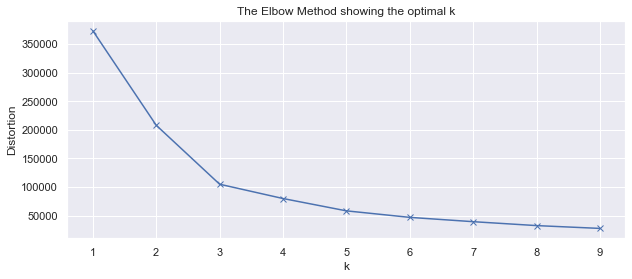

In [21]:
#elbow curve to find the optimal number of clusters. Answer = 4

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(GM_dim.iloc[:,1:5])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()  

(17,) (17,) (17,)
(1,) (1,) (1,)
(20,) (20,) (20,)
(18,) (18,) (18,)


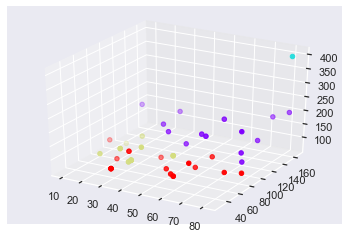

In [23]:
n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster, random_state = 0,max_iter=1000).fit(GM_dim.iloc[:,1:5])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
classes = kmeans.labels_
colors = cm.rainbow(np.linspace(0, 1, n_cluster))
for i in range(n_cluster):
    x=GM_dim.loc[classes == i, 'dim_packaging_length_mm']
    y=GM_dim.loc[classes == i, 'dim_packaging_width_mm']
    z=GM_dim.loc[classes == i, 'dim_packaging_height_mm']
    print(x.shape,y.shape, z.shape)
    ax.scatter(x, y, z, c=colors[i].reshape(1,-1))  

In [24]:
GM_dim['item_label'] = kmeans.labels_
GM_dim.sort_values(by=['item_label']).head(3)

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,item_vol,item_label
0,68495,50,120,130,46.80000,0
52,64439,73,165,170,122.85900,0
51,63087,77,123,141,80.12466,0


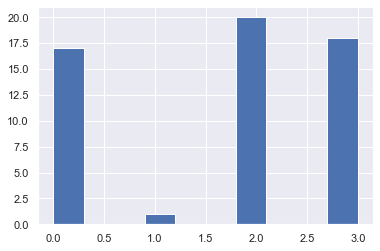

In [25]:
GM_dim['item_label'].hist()

In [30]:
GM_item_label = GM_dim[['variant_id','item_label','item_vol']].copy()
GM_item_label.to_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/Gm_item_labeled.csv', index = False)
GM_item_label.head(5)

,variant_id,item_label,item_vol
0,68495,0,46.80000
1,64018,0,46.80000
2,66664,3,16.14006
3,67094,3,32.28012
4,67095,0,48.42018


# Merge 3 datasets to create a feature matrix

In [ ]:
order_line_vol=pd.merge(line,GM_item_label, how='left', on = 'variant_id').dropna(subset = ['item_label'])
order_line_vol.head(2)

In [ ]:
line['order_number'].nunique()

In [ ]:
final1=pd.merge(order_line_vol,box_label, how='left', on='order_number').dropna(subset = ['FedEx_box_type'])

In [ ]:
final1

In [ ]:
final1['order_number'].nunique()

In [ ]:
# Calculate total order volume:

item_matrix_1 = pd.pivot_table(final1,
              index = ['order_number'],
              values = ['item_vol'],
              fill_value = 0,
              aggfunc ={ 'item_vol':sum} )

item_matrix_1.columns = ['total_order_vol']
item_matrix_1.reset_index(level=0, inplace=True)
item_matrix_1

In [ ]:
# Matrix with item type only
item_matrix_2 = pd.pivot_table(final1,
              index = ['order_number'],
              values = ['quantity'],
              columns = ['item_label'],
              fill_value = 0)

item_matrix_2.columns = ['item_size_0','item_size_1','item_size_2','item_size_3']
item_matrix_2.reset_index(level=0, inplace=True)
item_matrix_2

In [ ]:
item_matrix = pd.merge(item_matrix_2,item_matrix_1, how = 'left', on ='order_number')
item_matrix

In [ ]:
final_matrix = pd.merge(item_matrix,box_label, how ='left', on='order_number')
final_matrix

In [ ]:
final_matrix.to_csv('GM_box_size_clean_data_2509131600.csv', index=False)